# EDA 

### Objectives
**The Objectives of this notebook is to do following :**<br>
- Data Exploration 
- Fill the nan values 
- Univariate Analysis
- Preprocessing the data 


In [54]:
import numpy as np 
import pandas as pd 
import datetime 
import seaborn as sns 
import matplotlib.pyplot as plt 

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp) TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.”

- TransactionAMT: transaction payment amount in USD “Some of the transaction amounts have three decimal places to the right of the decimal point. There seems to be a link to three decimal places and a blank addr1 and addr2 field. Is it possible that these are foreign transactions and that, for example, the 75.887 in row 12 is the result of multiplying a foreign currency amount by an exchange rate?”

- ProductCD: product code, the product for each transaction “Product isn't necessary to be a real 'product' (like one item to be added to the shopping cart). It could be any kind of service.”

- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

- addr: address “both addresses are for purchaser
  - addr1 as billing region
  - addr2 as billing country”
- dist: distance "distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”
- P_ and (R__) emaildomain: purchaser and recipient email domain “ certain transactions don't need recipient, so R_emaildomain is null.”
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.




 - DeviceInfo : https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#583227

 - “id01 to id11 are numerical features for identity, which is collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc. All of these are not able to elaborate due to security partner T&C. I hope you could get basic meaning of these features, and by mentioning them as numerical/categorical, you won't deal with them inappropriately.”



In [55]:
df_train = pd.read_csv("Reduced_train.csv")
df_test = pd.read_csv("Reduced_test.csv")

### Some useful functions 

In [56]:
# This function returns the count of each values in the columns and Fraud % in each values. 

def count_and_perc_fraud_plot(df,col,size,title = ""):
    total = df_train.shape[0]
    perc_df = pd.crosstab(df_train[col],df_train["isFraud"],normalize = "index")*100
    perc_df =  perc_df.reset_index()
    perc_df.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize= size)    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    c1= sns.countplot( x=col,  data=df, order=list(perc_df[col].values))
    p1= c1.twinx()
    p1 = sns.pointplot(x=col, y='Fraud', data=perc_df, order=list(perc_df[col].values),
                       color='black', legend=False, )
    
    
    p1.set_ylim(0,perc_df['Fraud'].max()*1.1)
    p1.set_ylabel("%Fraud Transactions", fontsize=16)
    c1.set_title(f"Most Frequent {col} values and % Fraud Transactions" + title, fontsize=20)
    c1.set_xlabel(f"{col} Category Names", fontsize=16)
    c1.set_ylabel("Count", fontsize=17)
    c1.set_xticklabels(c1.get_xticklabels(),rotation=45)
    sizes = []
    for p in c1.patches:
        height = p.get_height()
        sizes.append(height)
        c1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12)
        
    c1.set_ylim(0,max(sizes)*1.15)
    plt.show()


In [57]:
# Distribution plots 
def distribution_plot(df,col,size = (5,5),title = ""):
    plt.figure(figsize= size)
    sns.distplot(df[col][df["isFraud"] == 1].dropna(),label="Fruad")
    sns.distplot(df[col][df["isFraud"] == 0].dropna(),label="NoFruad")
    plt.title(col + " Distribution")
    plt.legend()
    plt.show()

In [58]:
def imputer(df,col,type_):
    if type_ == "mean":
        df[col]=df[col].fillna(df[col].mean()[0])
    elif type_ == "median":
        df[col]=df[col].fillna(df[col].median()[0])
    elif type_ == "mode":
        df[col]=df[col].fillna(df[col].mode()[0])
    
    return df  

In [59]:
# columns names 
def columns_names(base_str,start_int,end_int):
    return [base_str + str(i) for i in range(start_int,end_int+1)]

# EDA 

In [60]:
columns = list(df_train.columns)

#### IsFraud

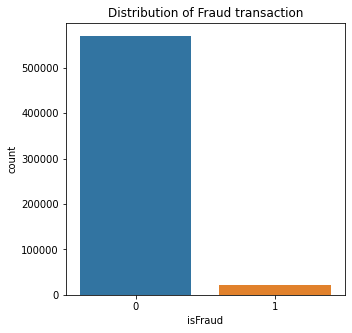

In [61]:
plt.figure(figsize=(5,5))
sns.countplot(x="isFraud",data = df_train)
plt.title("Distribution of Fraud transaction")
plt.show ()

**This shows that the dataset is highly imbalanced dataset .Therefore we will deal this probem while making the model.**

#### Transaction DT
 According to data description The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).
Since it is a timedelta ,exact date is note important </br> 

**Let's check that if the fraud is committed in a particular hour,Day_of_week,Day_of_month.**

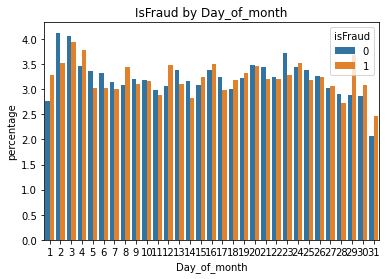

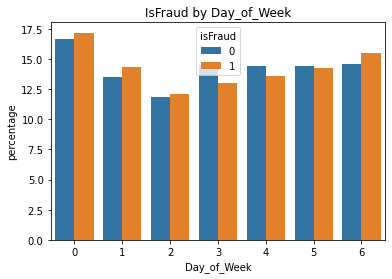

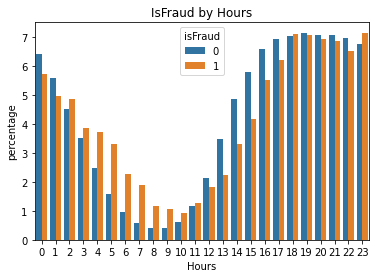

In [62]:
startdate = datetime.datetime.strptime('2019-12-01', '%Y-%m-%d')
df_train['trans_dt'] = df_train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
df_test['trans_dt'] = df_test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

df_train["Day_of_Week"]=df_train["trans_dt"].dt.dayofweek
df_train["Hours"]=df_train["trans_dt"].dt.hour
df_train["Day_of_month"]=df_train["trans_dt"].dt.day

df_test["Day_of_Week"]=df_test["trans_dt"].dt.dayofweek
df_test["Hours"]=df_test["trans_dt"].dt.hour
df_test["Day_of_month"]=df_test["trans_dt"].dt.day

for i in ["Day_of_month","Day_of_Week","Hours"]:
    plt.title("IsFraud by " + i)
    data = df_train.groupby(["isFraud"])[i].value_counts(normalize = True).mul(100).rename("percentage").reset_index().sort_values(i)
    sns.barplot(x = i , y = "percentage",hue= "isFraud",data = data)
    plt.show()

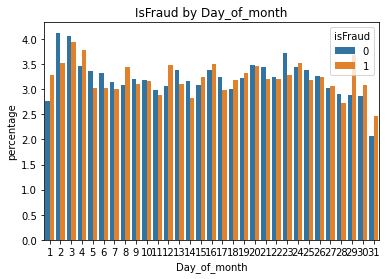

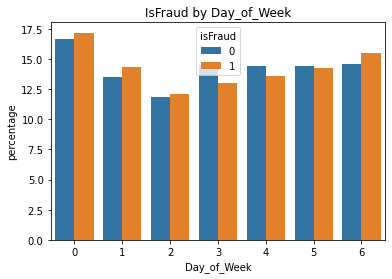

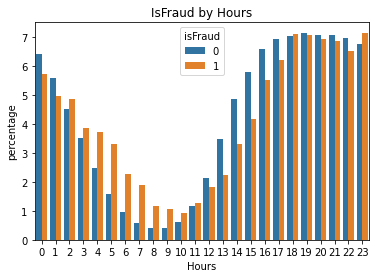

In [63]:
for i in ["Day_of_month","Day_of_Week","Hours"]:
    plt.title("IsFraud by " + i)
    data = df_train.groupby(["isFraud"])[i].value_counts(normalize = True).mul(100).rename("percentage").reset_index().sort_values(i)
    sns.barplot(x = i , y = "percentage",hue= "isFraud",data = data)
    plt.show()
    


**Now we explore the variable TransactionAmt**

In [64]:
df_train["TransactionAmt"].describe(percentiles=[0.99,0.90,0.75,0.50,0.25,0.10]).apply(lambda x: format(x, 'f'))

count    590540.000000
mean        135.027682
std         239.158822
min           0.251000
10%          25.950000
25%          43.300000
50%          68.750000
75%         125.000000
90%         275.200000
99%        1104.000000
max       31940.000000
Name: TransactionAmt, dtype: object

**There is a high variance in data . Lets see how the is tranaction amount distributed.We will consider 99% of values for plotting since there outliers in this column.** 


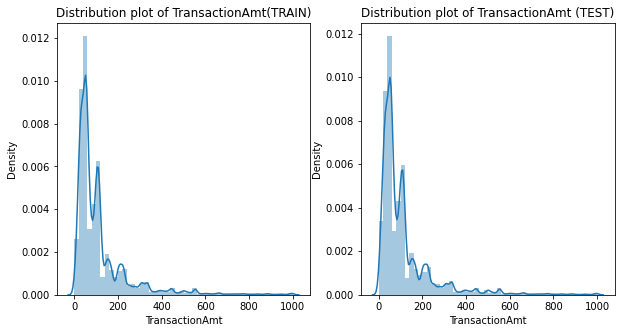

In [65]:

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Distribution plot of TransactionAmt(TRAIN)")
sns.distplot(df_train["TransactionAmt"][df_train["TransactionAmt"] <=1000])


plt.subplot(1,2,2)
plt.title("Distribution plot of TransactionAmt (TEST)")
sns.distplot(df_test["TransactionAmt"][df_test["TransactionAmt"] <=1000])
plt.show()



**We see that "TransactionDT" resembles a log-normal distribution witha very high. Therefore to convert this distribution in to normal distribution we have to apply log transformation.**

In [66]:
import warnings
warnings.filterwarnings("ignore")

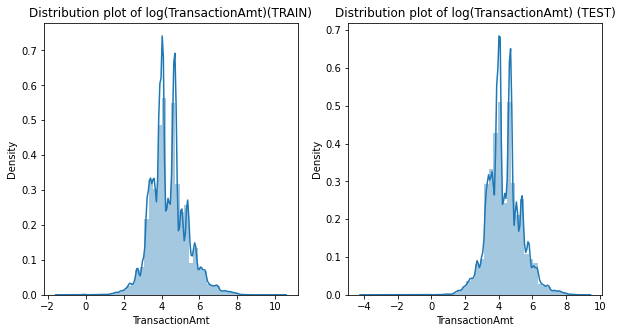

In [67]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Distribution plot of log(TransactionAmt)(TRAIN)")
sns.distplot(np.log(df_train["TransactionAmt"]))


plt.subplot(1,2,2)
plt.title("Distribution plot of log(TransactionAmt) (TEST)")
sns.distplot(np.log(df_test["TransactionAmt"]))
plt.show()

**Now this resembles normal distribution.**

In [68]:
df_train["TransactionAmt_log"] = np.log(df_train["TransactionAmt"])
df_test["TransactionAmt_log"] = np.log(df_test["TransactionAmt"])

### Product CD

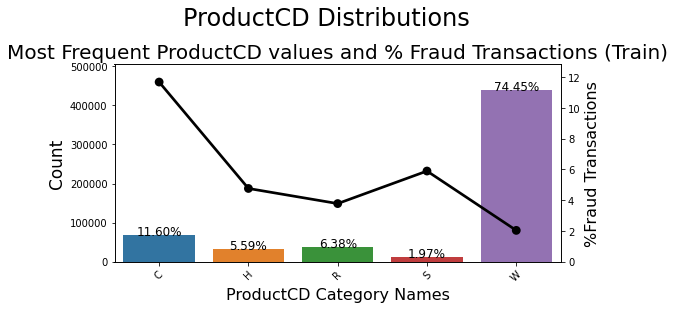

In [69]:
count_and_perc_fraud_plot(df_train,"ProductCD",size=(8,8),title=" (Train)")


### Card Variables

In [70]:
cards = columns_names('card',1,6)

In [71]:
df_train[cards].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


**It seems that card1,card2,car3 and card5 are continuous while card4 and card6 are categorical**

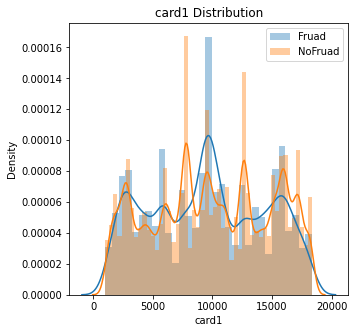

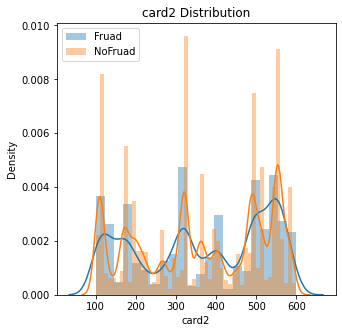

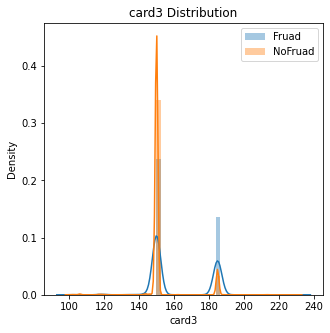

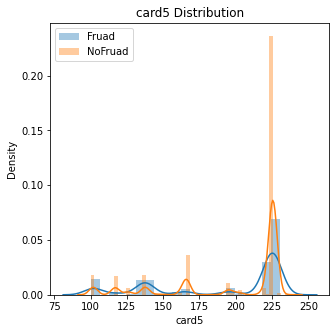

In [72]:
for card in ["card1","card2","card3","card5"]:
      distribution_plot(df_train,card,title="(TRAIN)")      

In [ ]:
card_1_vals = train['card1'].value_counts()
card_1_vals  = card_1_vals[card_1_vals>100]
card_1_vals = list(card_1_vals.index)
train['card1'] = np.where(train['card1'].isin(card_1_vals), train['card1'], "other")
test['card1']  = np.where(test['card1'].isin(card_1_vals), test['card1'], "other")

card_2_vals = train['card2'].value_counts()
card_2_vals  = card_2_vals[card_2_vals>1000]
card_2_vals = list(card_2_vals.index)
train['card2'] = np.where(train['card2'].isin(card_2_vals), train['card2'], "other")
test['card2']  = np.where(test['card2'].isin(card_2_vals), test['card2'], "other")


card_3_vals = train['card3'].value_counts()
card_3_vals  = card_3_vals[card_3_vals>962]
card_3_vals = list(card_3_vals.index)
train['card3'] = np.where(train['card3'].isin(card_3_vals), train['card3'], "other")
test['card3']  = np.where(test['card3'].isin(card_3_vals), test['card3'], "other")


card_5_vals = train['card5'].value_counts()
card_5_vals  = card_5_vals[card_5_vals>100]
card_5_vals = list(card_5_vals.index)
train['card5'] = np.where(train['card5'].isin(card_5_vals), train['card5'], "other")
test['card5']  = np.where(test['card5'].isin(card_5_vals), test['card5'], "other")

**The values of card1 , card2 are evenly distributed but the values of card3 and card5 are concentrated to some values values only . We can convert them into  categorical features**

In [24]:
df_train[cards].isnull().sum()

card1       0
card2    8933
card3    1565
card4    1577
card5    4259
card6    1571
dtype: int64

In [25]:
df_train[cards].nunique()

card1    13553
card2      500
card3      114
card4        4
card5      119
card6        4
dtype: int64

**Here we see that there are null values in card columns also  we see that these variable have very less unique value**<br>
**I think we can reduce the unique values of card1 to 200 , and do feature encoding**

In [73]:
card_1_vals = df_train['card1'].value_counts()
card_1_vals  = card_1_vals[card_1_vals>100]
card_1_vals = list(card_1_vals.index)
df_train['card1'] = np.where(df_train['card1'].isin(card_1_vals), df_train['card1'], "other")
df_test['card1']  = np.where(df_test['card1'].isin(card_1_vals), df_test['card1'], "other")




card_2_vals = df_train['card2'].value_counts()
card_2_vals  = card_2_vals[card_2_vals>1000]
card_2_vals = list(card_2_vals.index)
df_train['card2'] = np.where(df_train['card2'].isin(card_2_vals), df_train['card2'], "other")
df_test['card2']  = np.where(df_test['card2'].isin(card_2_vals), df_test['card2'], "other")


card_3_vals = df_train['card3'].value_counts()
card_3_vals  = card_3_vals[card_3_vals>962]
card_3_vals = list(card_3_vals.index)
df_train['card3'] = np.where(df_train['card3'].isin(card_3_vals), df_train['card3'], "other")
df_test['card3']  = np.where(df_test['card3'].isin(card_3_vals), df_test['card3'], "other")


card_5_vals = df_train['card5'].value_counts()
card_5_vals  = card_5_vals[card_5_vals>100]
card_5_vals = list(card_5_vals.index)
df_train['card5'] = np.where(df_train['card5'].isin(card_5_vals), df_train['card5'], "other")
df_test['card5']  = np.where(df_test['card5'].isin(card_5_vals), df_test['card5'], "other")
    


### Card4 Card6

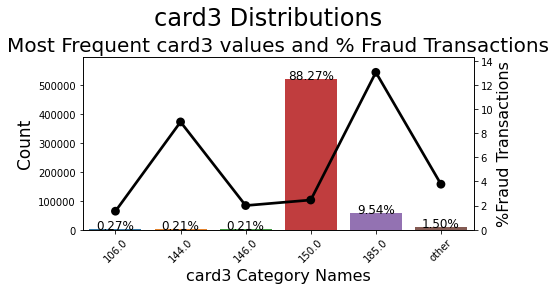

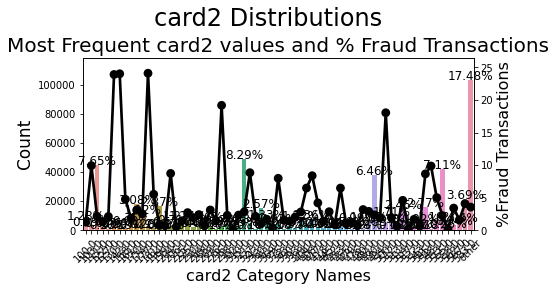

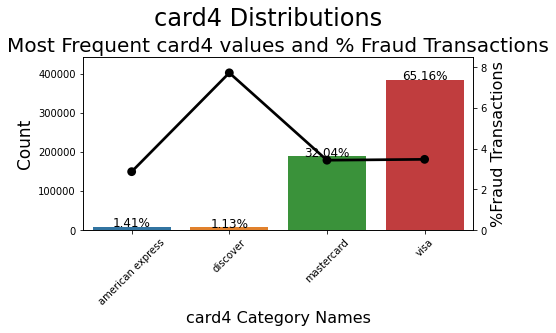

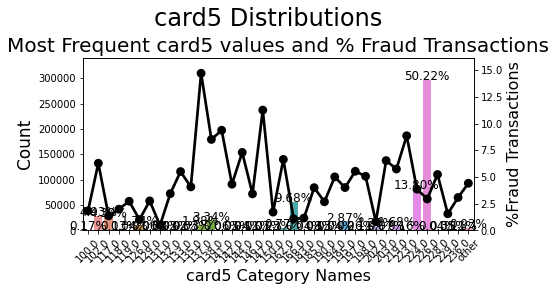

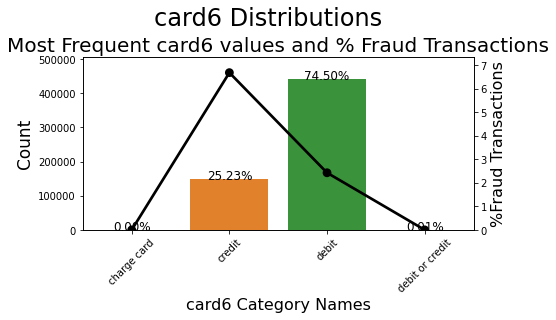

In [74]:
for i in ["card3","card2","card4","card5","card6"]:
    count_and_perc_fraud_plot(df_train,i,size = (7,7))


In [75]:
df_train = imputer(df_train,"card5","mode")
df_test = imputer(df_test,"card5","mode")

df_train = imputer(df_train,"card3","mode")
df_test = imputer(df_test,"card3","mode")


df_train = imputer(df_train,"card5","mode")
df_test = imputer(df_test,"card5","mode")

df_train = imputer(df_train,"card4","mode")
df_test = imputer(df_test,"card4","mode")

df_train = imputer(df_train,"card6","mode")
df_test = imputer(df_test,"card6","mode")

### addr variables

In [76]:
df_train.loc[df_train.addr1.isin(df_train.addr1.value_counts()[df_train.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
df_train.loc[df_train.addr2.isin(df_train.addr2.value_counts()[df_train.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"


df_test.loc[df_test.addr1.isin(df_test.addr1.value_counts()[df_test.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
df_test.loc[df_test.addr2.isin(df_test.addr2.value_counts()[df_test.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

In [77]:
df_train = imputer(df_train,"addr1","mode")
df_train = imputer(df_train,"addr2","mode")

df_test = imputer(df_test,"addr1","mode")
df_test = imputer(df_test,"addr2","mode")

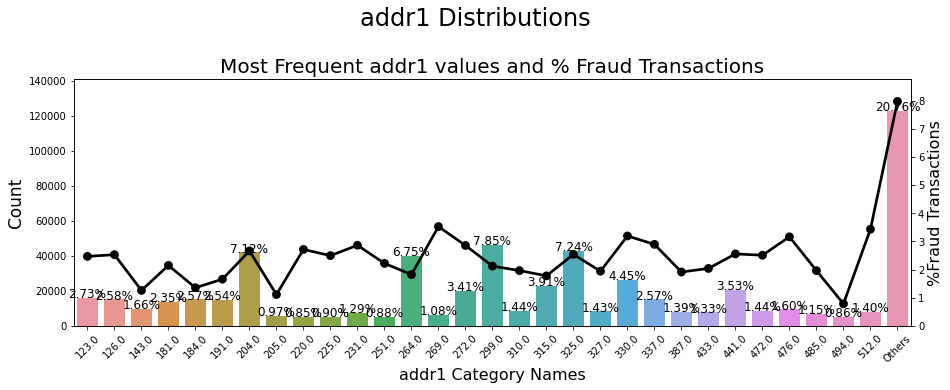

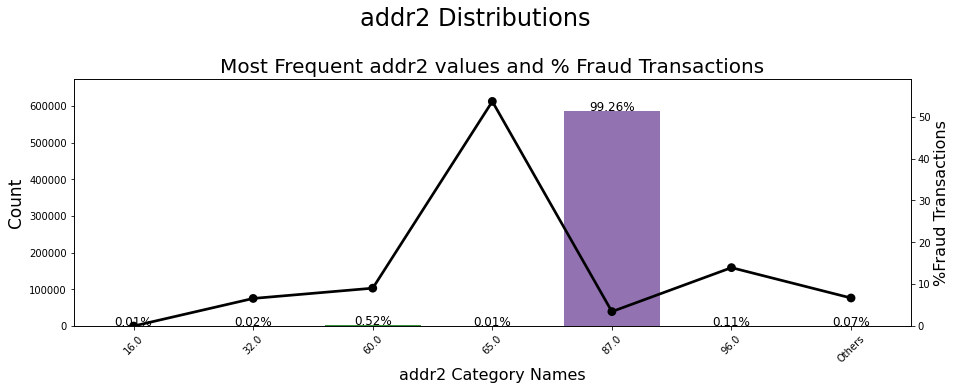

In [78]:
count_and_perc_fraud_plot(df_train,"addr1",size=(15,10))
count_and_perc_fraud_plot(df_train,"addr2",size=(15,10))


In [87]:
df_train = imputer(df_train,"addr1","mode")
df_train = imputer(df_train,"addr2","mode")

### Dist Variables

In [79]:
dist = columns_names("dist",1,2)

In [80]:
df_train[dist].isnull().sum()
df_train[dist].describe(percentiles=[0.99,0.90,0.75,0.50,0.25,0.10])

,dist1,dist2
count,238269.000000,37627.000000
mean,118.502344,231.856273
std,371.874253,529.061542
min,0.000000,0.000000
10%,1.000000,1.000000
25%,3.000000,7.000000
50%,8.000000,37.000000
75%,24.000000,206.000000
90%,268.000000,634.400000
99%,2040.000000,2367.480000


In [85]:
def feature_bin(df,col,v):
    vals = df[col].value_counts()
    vals  = vals[vals>v]
    vals = list(vals.index)
    df[col] = np.where(df[col].isin(vals), df[col], "other")
    return df


In [86]:
df_train =feature_bin(df_train,"dist1",505)
df_test =feature_bin(df_test,"dist1",505)

df_train =feature_bin(df_train,"dist2",505)
df_test =feature_bin(df_test,"dist2",505)

In [87]:
for i in dist:
    df_train = imputer(df_train,i,"mode")
    df_test = imputer(df_test,i,"mode")

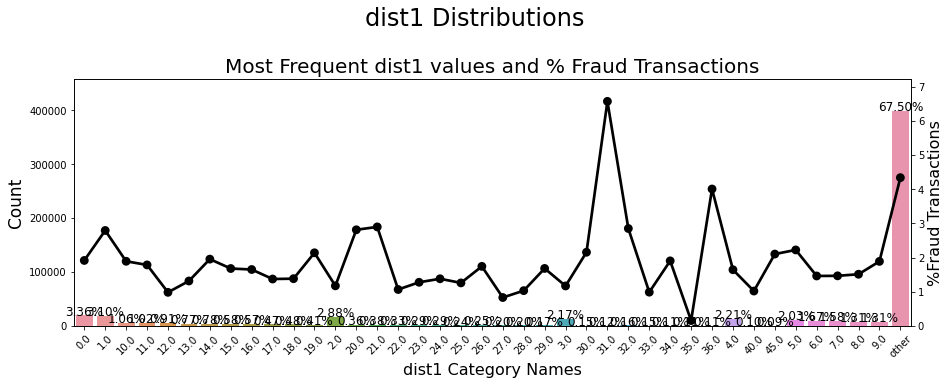

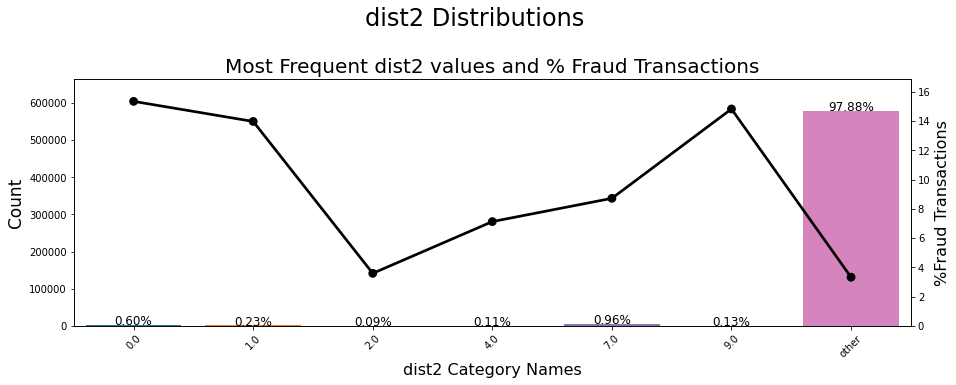

In [88]:
count_and_perc_fraud_plot(df_train,'dist1',size=(15,10))
count_and_perc_fraud_plot(df_train,'dist2',size=(15,10))


# D variables

In [89]:
D_vars = columns_names("D",1,15)
df_train[D_vars].isnull().sum()

D1       1269
D2     280797
D3     262878
D4     168922
D5     309841
D6     517353
D7     551623
D8     515614
D9     515614
D10     76022
D11    279287
D12    525823
D13    528588
D14    528353
D15     89113
dtype: int64

https://www.kaggle.com/rajeshcv/unique-card-identifier-features-from-c-d-columns

In [90]:
df_train[D_vars] =df_train[D_vars].fillna(0)
df_test[D_vars] =df_test[D_vars].fillna(0)

In [91]:
corr = df_train[D_vars].corr()
corr.style.background_gradient(cmap='coolwarm')

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
D1,1.000000,0.972853,0.369089,0.482897,0.125187,0.065224,0.026540,-0.060018,-0.117760,0.569123,0.477461,0.047117,0.043638,-0.017293,0.638353
D2,0.972853,1.000000,0.327788,0.477817,0.115042,0.057322,0.021664,-0.058290,-0.116916,0.566002,0.475252,0.035397,0.041756,-0.017857,0.628565
D3,0.369089,0.327788,1.000000,0.205503,0.356582,0.090276,0.146542,-0.034405,-0.068670,0.183775,0.123798,0.100535,0.045797,0.000260,0.229910
D4,0.482897,0.477817,0.205503,1.000000,0.433253,0.142152,0.118332,-0.076504,-0.131371,0.539460,0.461140,0.178702,0.044596,-0.023066,0.650095
D5,0.125187,0.115042,0.356582,0.433253,1.000000,0.180445,0.348458,-0.029288,-0.063209,0.176226,0.115579,0.194041,0.041935,0.003625,0.248290
D6,0.065224,0.057322,0.090276,0.142152,0.180445,1.000000,0.599899,0.117853,0.186943,-0.018214,-0.078324,0.734026,0.346381,0.212954,0.058067
D7,0.026540,0.021664,0.146542,0.118332,0.348458,0.599899,1.000000,0.054701,0.057483,-0.030700,-0.049993,0.508665,0.155204,0.090735,0.020299
D8,-0.060018,-0.058290,-0.034405,-0.076504,-0.029288,0.117853,0.054701,1.000000,0.463871,-0.095551,-0.097332,0.067248,0.244343,0.081930,-0.094362
D9,-0.117760,-0.116916,-0.068670,-0.131371,-0.063209,0.186943,0.057483,0.463871,1.000000,-0.168568,-0.164106,0.128486,0.171242,0.156358,-0.175689
D10,0.569123,0.566002,0.183775,0.539460,0.176226,-0.018214,-0.030700,-0.095551,-0.168568,1.000000,0.521163,-0.081758,-0.017140,-0.033981,0.711733


## M variables


In [92]:
M_vars = columns_names("M",1,9)

In [95]:
for i in M_vars:
    df_train = imputer(df_train,i,"mode")
    df_test = imputer(df_test,i,"mode")

Except for M4 all the other variable values are in booleans 

In [96]:
def cat_plots(df,col,size):
    df[col].fillna("NA",inplace = True)
    fraud_perc = df.groupby(col)["isFraud"].value_counts(normalize = True).unstack().fillna(0)[1]
    
    plt.figure(figsize = size)
    
    g = sns.countplot(x = col,data = df,order = fraud_perc.index)
    g.set_title("{} Count".format(col),fontsize= 15)
    g.set_xlabel("{}".format(col),fontsize=15)
    g.set_ylabel("Count",fontsize=15)
    plt.xticks(rotation = "vertical")
    
    r = g.twinx()
    r = sns.pointplot(x = fraud_perc.index,y = fraud_perc,color = "blue")
    r.set_ylabel("Fraud Rate",fontsize = 16,color = "blue")
    
    
    

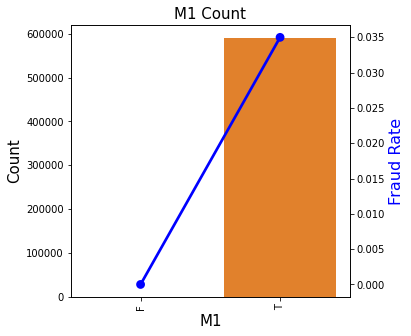

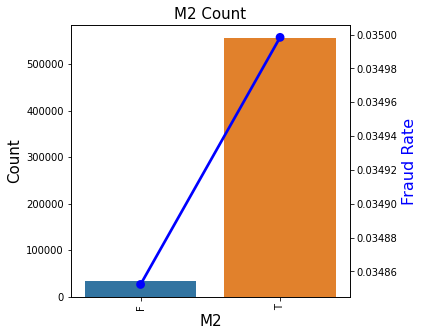

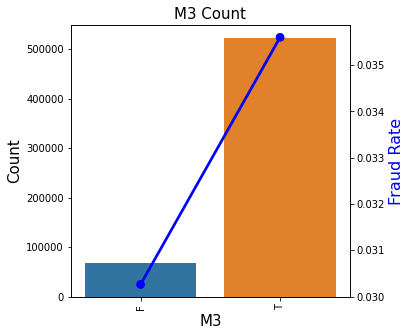

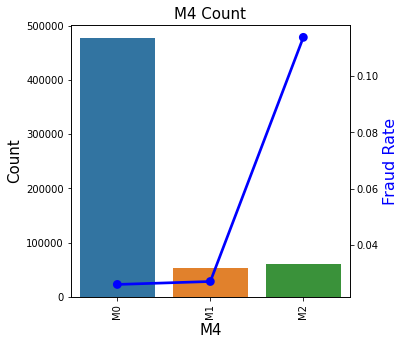

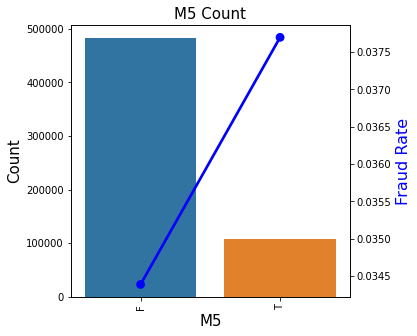

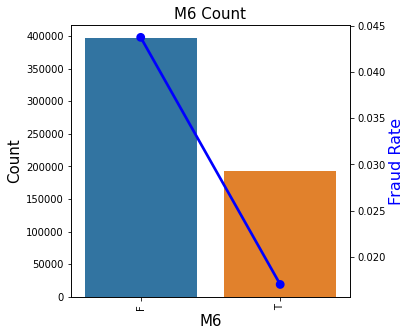

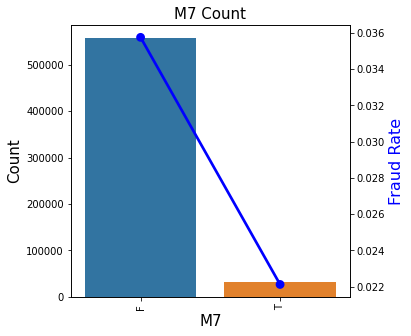

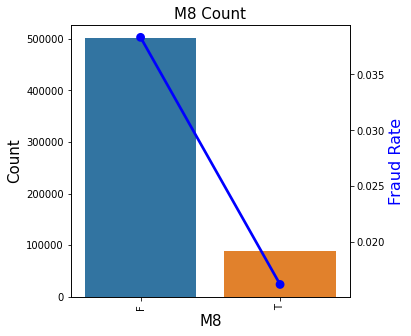

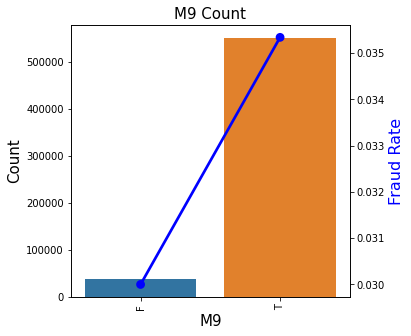

In [98]:
for i in M_vars:
    cat_plots(df_train,i,size = (5,5))


## Device Info

In [99]:
devices = df_train.groupby("DeviceInfo").filter(lambda x :  len(x) > 250)["DeviceInfo"].unique()

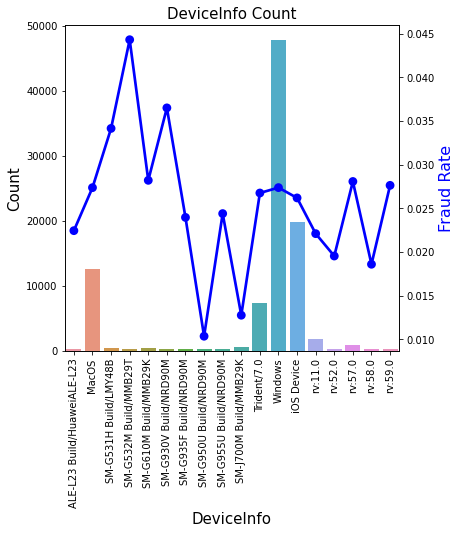

In [100]:
cat_plots(df = df_train[df_train["DeviceInfo"].isin(devices)],col = "DeviceInfo",size = (6,6))

In [103]:
df_train["DeviceInfo"] = df_train["DeviceInfo"].fillna("other")
df_test["DeviceInfo"] = df_test["DeviceInfo"].fillna("other")

# Emails

There seem to be alot of related emails 

In [104]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum',
'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr'
: 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com':
'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 
'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 
'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 
'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 
'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 
'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 
'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink',
'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 
'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 
'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 
'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com':
'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com':
'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 
'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']
for c in ['P_emaildomain', 'R_emaildomain']:
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)
    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

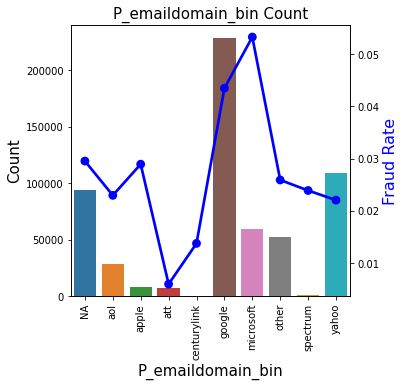

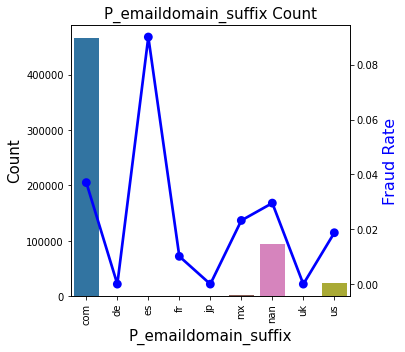

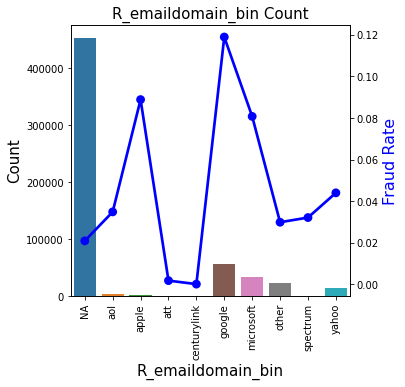

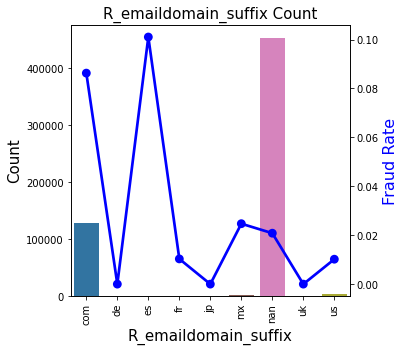

In [105]:
for i in ["P_emaildomain_bin","P_emaildomain_suffix","R_emaildomain_bin","R_emaildomain_suffix"]:
                    cat_plots(df_train,i,size=(5,5))


In [115]:
df_train["P_emaildomain_suffix"] = df_train["P_emaildomain_suffix"].fillna("Unknown")
df_test["P_emaildomain_suffix"] = df_test["P_emaildomain_suffix"].fillna("Unknown")

df_train["P_emaildomain_bin"] = df_train["P_emaildomain_bin"].fillna("Unknown")
df_test["P_emaildomain_bin"] = df_test["P_emaildomain_bin"].fillna("Unknown")



df_train["R_emaildomain_suffix"]  =df_train["R_emaildomain_suffix"].fillna("Unknown")
df_test["R_emaildomain_suffix"]  =df_test["R_emaildomain_suffix"].fillna("Unknown")


df_train["R_emaildomain_bin"]  =df_train["R_emaildomain_bin"].fillna("Unknown")
df_test["R_emaildomain_bin"]  =df_test["R_emaildomain_bin"].fillna("Unknown")


In [127]:
df_train = df_train.drop(["P_emaildomain","R_emaildomain"],axis=1)
df_test = df_test.drop(["P_emaildomain","R_emaildomain"],axis=1)

### C variables

In [106]:
c_vars = columns_names("C",1,14)

In [107]:
c_vars = columns_names("C",1,14)
C_vars = df_train[c_vars]

- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc.
- The actual meaning is masked. “Can you please give more examples of counts in the variables C1-15? 
- Would these be like counts of phone numbers, email addresses, names associated with the user? 
- I can't think of 15. Your guess is good, plus like device, ipaddr, billingaddr, etc. 
- Also these are for both purchaser and recipient, which doubles the number

In [108]:
corr = C_vars.corr()
corr.style.background_gradient(cmap='coolwarm')

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
C1,1.000000,0.995090,-0.003467,0.967801,0.165865,0.982239,0.926256,0.967746,0.176002,0.958202,0.996516,0.927938,0.774605,0.951763
C2,0.995090,1.000000,-0.003339,0.972133,0.126538,0.974843,0.938869,0.975864,0.133563,0.970625,0.993897,0.940261,0.751219,0.936146
C3,-0.003467,-0.003339,1.000000,-0.001720,-0.008101,-0.004711,-0.001730,-0.001203,-0.010074,-0.001494,-0.003583,-0.001763,-0.007747,-0.005091
C4,0.967801,0.972133,-0.001720,1.000000,-0.012842,0.962319,0.895092,0.959995,-0.015970,0.952466,0.974547,0.894618,0.644549,0.907676
C5,0.165865,0.126538,-0.008101,-0.012842,1.000000,0.232409,-0.009970,-0.011654,0.925786,-0.011846,0.168861,-0.009875,0.717509,0.378950
C6,0.982239,0.974843,-0.004711,0.962319,0.232409,1.000000,0.858583,0.921972,0.250695,0.914440,0.991104,0.858182,0.808530,0.984201
C7,0.926256,0.938869,-0.001730,0.895092,-0.009970,0.858583,1.000000,0.982983,-0.012399,0.985061,0.915210,0.999489,0.632393,0.794701
C8,0.967746,0.975864,-0.001203,0.959995,-0.011654,0.921972,0.982983,1.000000,-0.014492,0.996970,0.962722,0.983027,0.653244,0.860246
C9,0.176002,0.133563,-0.010074,-0.015970,0.925786,0.250695,-0.012399,-0.014492,1.000000,-0.014731,0.182444,-0.012212,0.704056,0.397396
C10,0.958202,0.970625,-0.001494,0.952466,-0.011846,0.914440,0.985061,0.996970,-0.014731,1.000000,0.956056,0.983816,0.653941,0.853009


**These are  higly correlated featured variables**<br>
**We will have to see how these featured interact with other features**

## DEVICE INFO

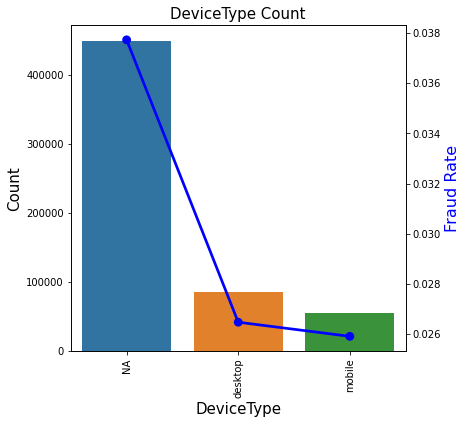

In [109]:
cat_plots(df_train,'DeviceType',size = (6,6))

In [111]:
df_train['DeviceType'] = df_train['DeviceType'].map({'desktop':1, 'mobile':0})
df_test['DeviceType'] = df_test['DeviceType'].map({'desktop':1, 'mobile':0})

In [116]:
df_train[['DeviceType','DeviceInfo']] = df_train[['DeviceType','DeviceInfo']].fillna("Unknown")
df_test[['DeviceType','DeviceInfo']] = df_test[['DeviceType','DeviceInfo']].fillna("Unknown")

## Id variables 

In [112]:
id_num_vars_train = columns_names("id_0",1,9)
id_num_vars_train.extend(columns_names("id_",10,38))
id_num_vars_test = columns_names("id-0",1,9)
id_num_vars_test.extend(columns_names("id-",10,38))
rename_dict = dict(zip(id_num_vars_test,id_num_vars_train))
df_test = df_test.rename(rename_dict,axis='columns')

In [121]:
df_train.loc[df_train['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
df_train.loc[df_train['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
df_train.loc[df_train['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
df_train.loc[df_train['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
df_train['id_30'].fillna("NAN", inplace=True)

df_test.loc[df_test['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
df_test.loc[df_test['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
df_test.loc[df_test['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
df_test.loc[df_test['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
df_test['id_30'].fillna("NAN", inplace=True)

In [119]:
ids =  ["id_12","id_15","id_16","id_23","id_27","id_28","id_29","id_32","id_34","id_35","id_36","id_37","id_38"]

In [120]:
for i in ids:
    df_train = imputer(df_train,i,"mode")
    df_test = imputer(df_test,i,"mode")

In [122]:
def data_red(df):
    df['id_12'] = df['id_12'].map({'Found':1, 'NotFound':0})
    df['id_15'] = df['id_15'].map({'New':2, 'Found':1, 'Unknown':0})
    df['id_16'] = df['id_16'].map({'Found':1, 'NotFound':0})

    df['id_23'] = df['id_23'].map({'TRANSPARENT':4, 'IP_PROXY':3, 'IP_PROXY:ANONYMOUS':2, 'IP_PROXY:HIDDEN':1})

    df['id_27'] = df['id_27'].map({'Found':1, 'NotFound':0})
    df['id_28'] = df['id_28'].map({'New':2, 'Found':1})

    df['id_29'] = df['id_29'].map({'Found':1, 'NotFound':0})

    df['id_35'] = df['id_35'].map({'T':1, 'F':0})
    df['id_36'] = df['id_36'].map({'T':1, 'F':0})
    df['id_37'] = df['id_37'].map({'T':1, 'F':0})
    df['id_38'] = df['id_38'].map({'T':1, 'F':0})

    df['id_34'] = df['id_34'].fillna(':0')
    df['id_34'] = df['id_34'].apply(lambda x: x.split(':')[1]).astype(np.int8)
    df['id_34'] = np.where(df['id_34']==0, np.nan, df['id_34'])

    df['id_33'] = df['id_33'].fillna('0x0')
    df['id_33_0'] = df['id_33'].apply(lambda x: x.split('x')[0]).astype(int)
    df['id_33_1'] = df['id_33'].apply(lambda x: x.split('x')[1]).astype(int)
    df['id_33'] = np.where(df['id_33']=='0x0', np.nan, df['id_33'])


    return df 

In [123]:
df_train = data_red(df_train)
df_test = data_red(df_test)

In [131]:
na_ids  =['id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_13',
 'id_14',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_31',
 'id_33',
 'id_34']

## V vars 

In [133]:
df_train["id_02"] = df_train["id_02"].fillna(df_train["id_02"].median())
df_train[["id_03"]] = df_train[["id_03"]].fillna(0)
df_train[["id_04"]] = df_train[["id_04"]].fillna(0)
df_train[["id_05"]] = df_train[["id_04"]].fillna(0)

In [134]:
df_test["id_02"] = df_test["id_02"].fillna(df_test["id_02"].median())
df_test[["id_03"]] = df_test[["id_03"]].fillna(0)
df_test[["id_04"]] = df_test[["id_04"]].fillna(0)
df_test[["id_05"]] = df_test[["id_04"]].fillna(0)

In [135]:
df_train["id_31"] = df_train["id_31"].fillna("other")
df_train["id_31"] = df_train["id_31"].apply(lambda x : x.split(" ")[0])

df_test["id_31"] = df_test["id_31"].fillna("other")
df_test["id_31"] = df_test["id_31"].apply(lambda x : x.split(" ")[0])

In [137]:
f_ids = ['id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25',
       'id_26']

In [139]:
for i in f_ids:
    df_train[i] = df_train[i].fillna(df_train[i].median())
    
for i in f_ids:
    df_test[i] = df_test[i].fillna(df_test[i].median())

In [ ]:
id_01    
id_23    
id_33    
id_34  

In [159]:
df_train = feature_bin(df_train,"id_01",200)
df_test = feature_bin(df_test,"id_01",200)

In [165]:
df_train["id_34"] = df_train["id_34"].fillna(0)
df_test["id_34"] = df_test["id_34"].fillna(0)
df_train["id_23"] = df_train["id_23"].fillna(0)
df_test["id_23"] = df_test["id_23"].fillna(0)


In [161]:
df_train["id_23"].value_counts()

2.0    1071
1.0     609
Name: id_23, dtype: int64

In [157]:
df_train["id_01"].value_counts()[df_train["id_01"].value_counts()>200]

-5.0      82170
 0.0      19555
-10.0     11257
-20.0     11211
-15.0      5674
-25.0      4623
-45.0      2143
-35.0      1622
-40.0      1385
-100.0     1012
-50.0       709
-30.0       682
-95.0       428
-60.0       410
-55.0       320
-80.0       220
-90.0       214
Name: id_01, dtype: int64

In [148]:
df_train = df_train.drop(["id_33"],axis=1)
df_test = df_test.drop(["id_33"],axis=1)

In [168]:
df_train.to_csv("Modeltrain.csv")
df_test.to_csv("Modeltest.csv")

In [167]:
df_test.isnull().sum()[df_train.isnull().sum()>0]

V1      176518
V2      176518
V3      176518
V4      176518
V5      176518
         ...  
V335    430260
V336    430260
V337    430260
V338    430260
V339    430260
Length: 339, dtype: int64